The fitting may need to be done several times to find the best range of the parameters. After these adjustments, all parameters have few outliers. And it is possible to use np.interp to interpolate some of the parameter-vs-E curves.

# Tools

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import histogram.hdf as hh, histogram as H
import lmfit

In [3]:
from dgsres import icg

# Fit

In [4]:
from dgsres.powder import fit

In [16]:
params = lmfit.Parameters()
# at first the max was 1.0. after trying it, it seems better to set max to 0.6 because points outside the range look like outliers
params.add('a', min=0., max=.3)
# at first the max was 0.3. 
params.add('b', min=0., max=.045)
params.add('R', value=0.3, vary=False)
params.add('sigma', min=0., max=20.)
params.add('t0', min=0., max=100.)

Ei = 30.
geom = icg.Geom(l1=11.6, l2=2.0, l3=3.)

fitIE = fit.Fit_IE(
    simout="/SNS/users/lj7/simulations/ARCS/graphite/resolution/Ei_30/out/",
    Ei=Ei,
    params = params,
    geom = geom,
)
Q = 3.

In [17]:
%%time
results = {}
for E0 in np.arange(0., Ei-1, 3.):
    print E0
    results[E0] = fitIE.fit(Q=Q, E=E0)
    continue

0.0
3.0
6.0
9.0
12.0
15.0
18.0
21.0
24.0
27.0
CPU times: user 18.9 s, sys: 68 ms, total: 19 s
Wall time: 19 s


<IPython.core.display.Javascript object>


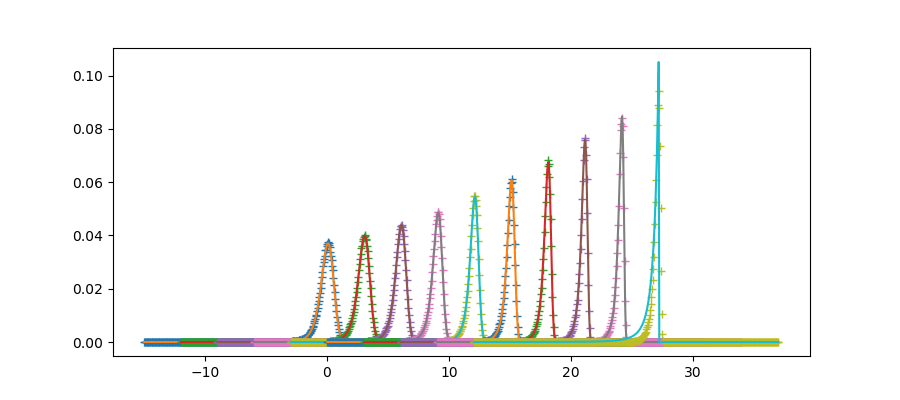

In [18]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., Ei-1, 3.):
    x,y0,y0err = fitIE.getData(Q, E0)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **results[E0].params.valuesdict())
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

In [19]:
E0s = np.arange(0., Ei-1, 3.)
def get_p_list(name):
    return [results[E0].params[name].value for E0 in E0s]

The plot generated by the following cell can clearly show how many outliers exist for parameters. Try to minimize the number of outliers by changing the parameters (up in the `fitting parameters` section) and execute all the cells in between that cell and the next cell

<IPython.core.display.Javascript object>


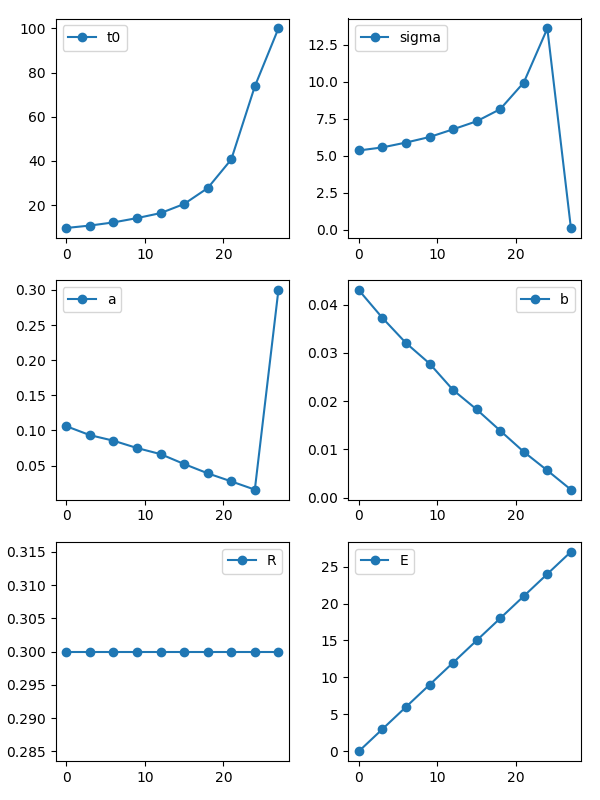

In [20]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))
for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    plt.plot(E0s, get_p_list(v), '-o', label=v)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
E0 = 0.
print results[E0].params['a'].value
print results[E0].params['b'].value

0.10603705516
0.042997513011


# Interpolate

## a

<IPython.core.display.Javascript object>


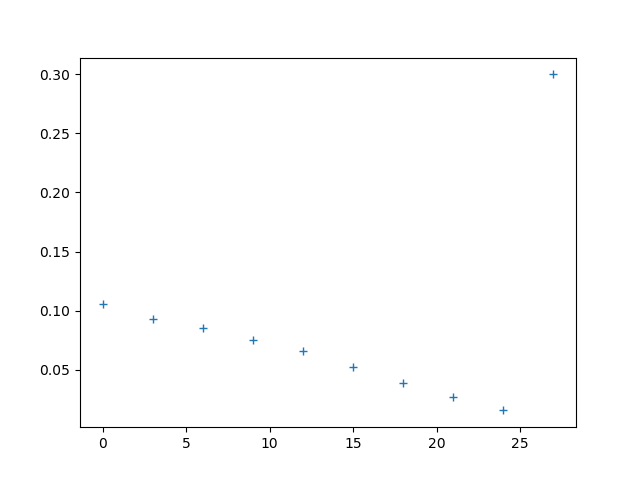

In [22]:
plt.figure()
x = E0s
y = np.array(get_p_list('a'))
plt.plot(x, y, '+')

There is one outlier. Here for simplicity we remove two points

In [23]:
good = x < 25
xgood = x[good]; ygood = y[good]

<IPython.core.display.Javascript object>


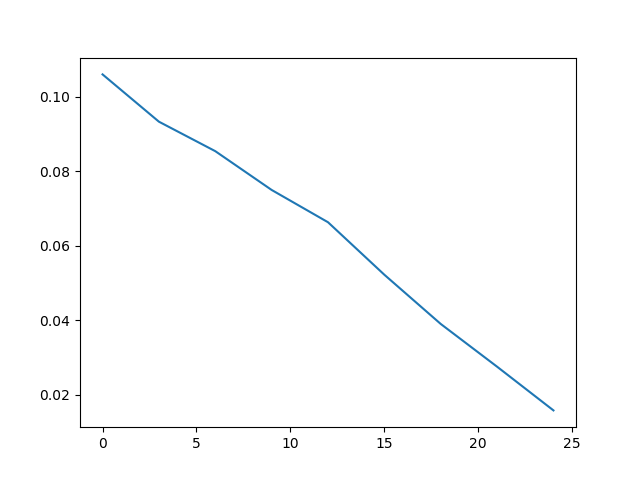

In [24]:
plt.figure()
plt.plot(xgood, ygood)

In [25]:
a2, a1, a0 = np.polyfit(xgood, ygood, 2)

<IPython.core.display.Javascript object>


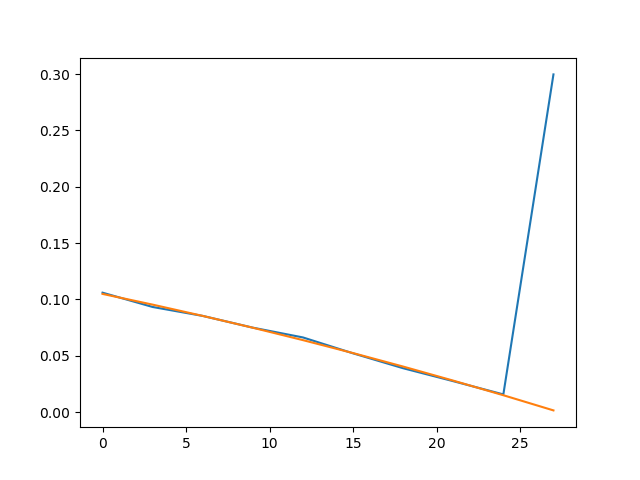

In [26]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [27]:
a0_a = a0; a1_a = a1; a2_a = a2

## b

<IPython.core.display.Javascript object>


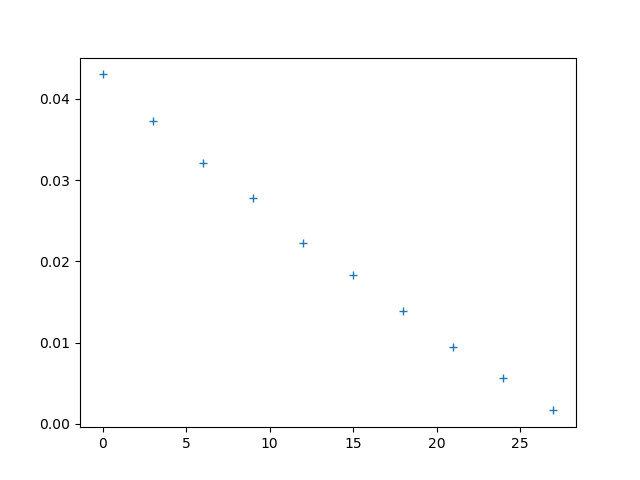

In [28]:
plt.figure()
x = E0s
y = np.array(get_p_list('b'))
plt.plot(x, y, '+')

In [29]:
a2, a1, a0 = np.polyfit(x, y, 2)

<IPython.core.display.Javascript object>


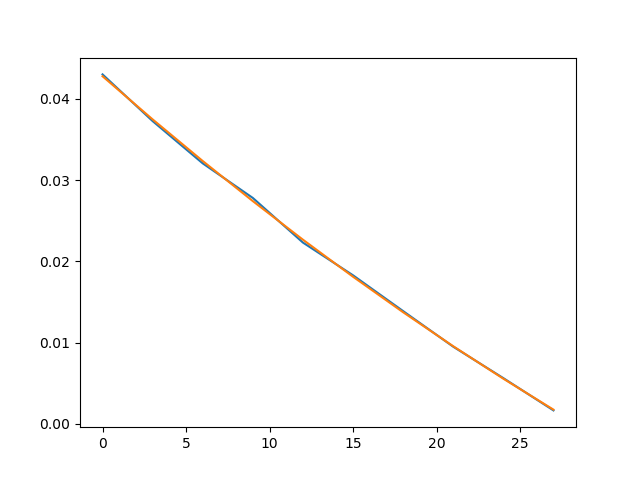

In [30]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [31]:
a0_b = a0; a1_b = a1; a2_b = a2

## t0
a and b are easy to fit. But t0 and sigma are harder to fit. We just do a simple interpolation

<IPython.core.display.Javascript object>


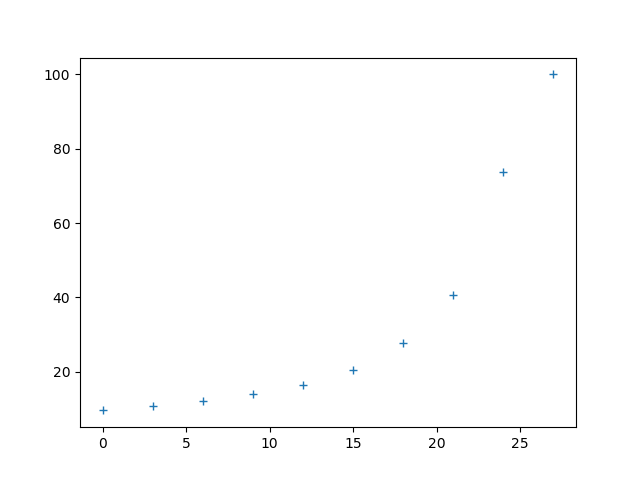

In [32]:
plt.figure()
plt.plot(E0s, get_p_list('t0'), '+')

There is no outlier

In [33]:
x_t0 = E0s.copy(); y_t0 = np.array(get_p_list('t0'))

## sigma

<IPython.core.display.Javascript object>


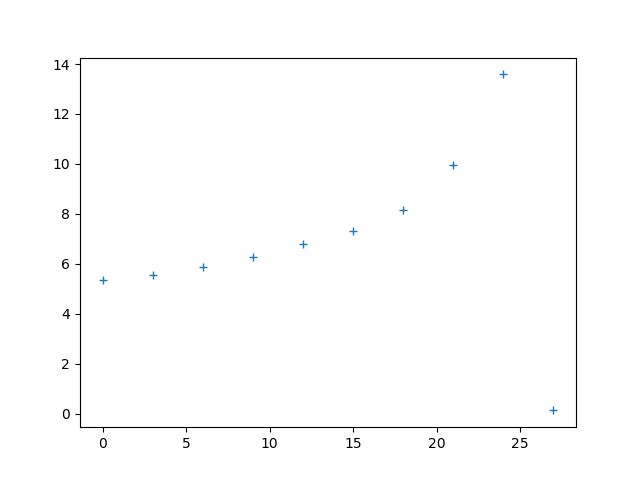

In [34]:
plt.figure()
plt.plot(E0s, get_p_list('sigma'), '+')

There is one outlier

In [35]:
mask = E0s < 25.
x_sigma = E0s.copy()[mask]; y_sigma = np.array(get_p_list('sigma'))[mask]

# Save parameters

In [36]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [37]:
pwd

u'/home/lj7/dv/srins/graphite-DOS/notebooks'

In [38]:
%%writetemplate res_params_interped_funcs_Ei_30.py
import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = {a0_a}
a1_a = {a1_a}
a2_a = {a2_a}
a0_b = {a0_b}
a1_b = {a1_b}
a2_b = {a2_b}
from numpy import array
x_t0 = {x_t0!r}
y_t0 = {y_t0!r}
x_sigma = {x_sigma!r}
y_sigma = {y_sigma!r}

interped_funcs = dict(
    a = parabolic(a0_a, a1_a, a2_a),
    b = parabolic(a0_b, a1_b, a2_b),
    t0 = lambda E: np.interp(E, x_t0, y_t0),
    sigma = lambda E: np.interp(E, x_sigma, y_sigma),
    R = lambda E: 0*E+ 0.3, 
)

In [39]:
cat res_params_interped_funcs_Ei_30.py

import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = 0.104931825542
a1_a = -0.00308897959471
a2_a = -2.73934309733e-05
a0_b = 0.0427686908818
a1_b = -0.00180090823431
a2_b = 1.04406206398e-05
from numpy import array
x_t0 = array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.])
y_t0 = array([  9.6005304 ,  10.68959831,  12.12003543,  14.07073622,
        16.3378882 ,  20.48146884,  27.67687584,  40.6573301 ,
        73.78375141,  99.998578  ])
x_sigma = array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.])
y_sigma = array([  5.36060065,   5.56703294,   5.89412131,   6.26706768,
         6.78693453,   7.32914165,   8.14617741,   9.94035219,  13.58436784])

interped_funcs = dict(
    a = parabolic(a0_a, a1_a, a2_a),
    b = parabolic(a0_b, a1_b, a2_b),
    t0 = lambda E: np.interp(E, x_t0, y_t0),
    sigma = lambda E: np.interp(E, x_sigma, y_sigma),
    R = lambda E: 0*E+ 0.3, 
)

In [40]:
import res_params_interped_funcs_Ei_30 as rpif
reload(rpif)

<module 'res_params_interped_funcs_Ei_30' from 'res_params_interped_funcs_Ei_30.pyc'>

# Test the interpolation / fitting

<IPython.core.display.Javascript object>


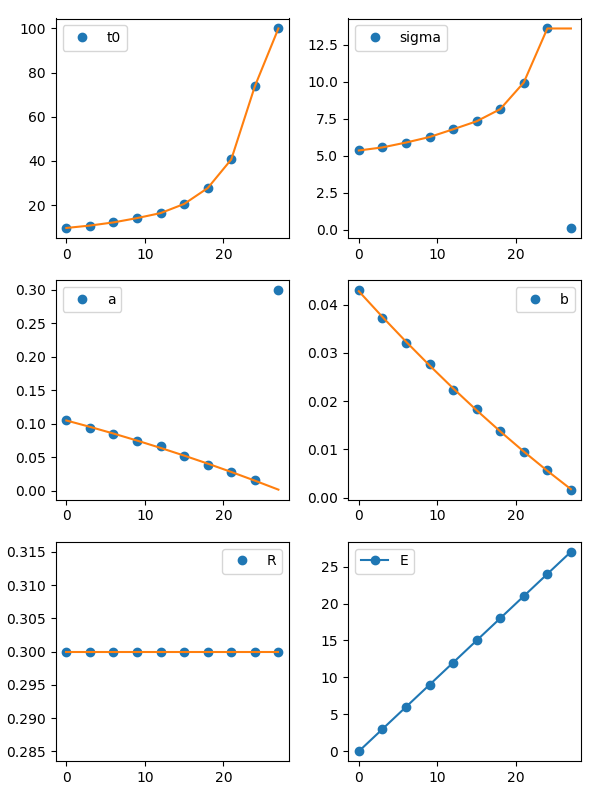

In [41]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))

for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    x, y = E0s, get_p_list(v)
    plt.plot(x, y, 'o', label=v)
    # print v; break
    y2 = rpif.interped_funcs[v](x)
    plt.plot(x, y2)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

Compare to sim data

<IPython.core.display.Javascript object>


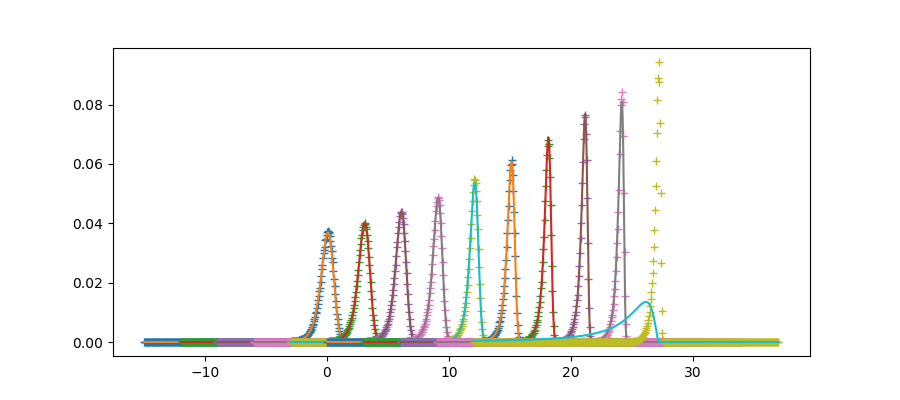

In [42]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., Ei-1, 3.):
    x,y0,y0err = fitIE.getData(Q, E0)
    params = dict()
    for name in rpif.interped_funcs.keys():
        value = rpif.interped_funcs[name](E0)
        params[name] = value
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x, y0, '+')
    plt.plot(x, y)
plt.show()

Try some Energy transfer values that were not simulated by mcvine

In [43]:
interped_funcs = rpif.interped_funcs

<IPython.core.display.Javascript object>


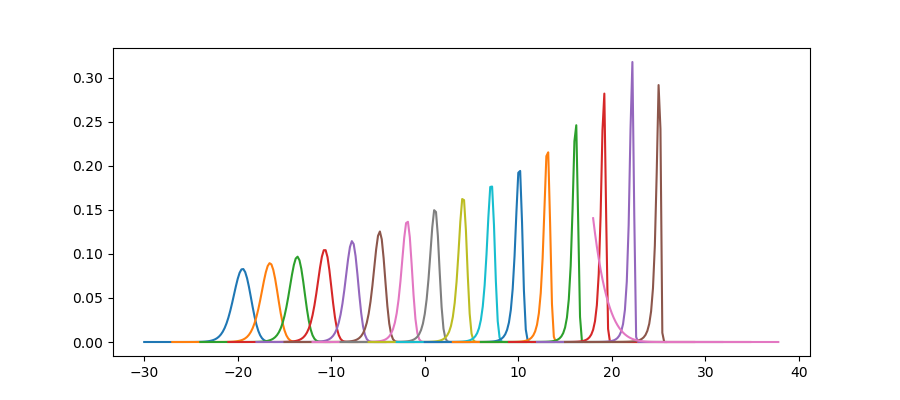

In [45]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(-20., 29., 3.):
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    x = np.arange(E0-10, E0+10, 0.2)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x, y)
plt.show()

It is not very good after 23meV